# Multi Layer Neural Network on large Dataset

In [1]:
# imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set()

import sklearn
from sklearn import model_selection, preprocessing

import tensorflow as tf
from tensorflow.keras import layers, models, metrics

from scipy import stats

pd.set_option("display.precision", 2)
pd.set_option('display.max_columns', None)

load data into a dataframe, remove unwanted columns then describe it.

In [3]:
# load data into a df
dota_df = pd.read_csv("../data/dota2_matches_large_encoded.csv")


enc = preprocessing.OneHotEncoder()
for column in ['lobby_type']:
    encoded = enc.fit_transform(np.array(dota_df[column]).reshape(-1,1))
    encoded_names = [column + '_' + str(i) for i in range(len(encoded.toarray()[0]))]
    dota_df.loc[:, encoded_names] = encoded.toarray().astype(bool)

dota_df.drop('lobby_type', axis=1, inplace=True)

dota_df.describe()

,dire_rating,dire_wins,dire_losses,radiant_rating,radiant_wins,radiant_losses,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29,cluster_30,cluster_31,cluster_32,cluster_33,cluster_34,cluster_35,cluster_36,cluster_37,cluster_38,cluster_39,cluster_40,cluster_41,cluster_42,cluster_43,cluster_44,cluster_45,cluster_46,cluster_47,cluster_48,cluster_49,cluster_50,cluster_51,cluster_52,cluster_53,cluster_54,cluster_55,cluster_56,cluster_57,cluster_58,cluster_59,cluster_60,cluster_61,cluster_62,cluster_63,cluster_64,cluster_65,cluster_66,cluster_67,game_mode_0,game_mode_1,game_mode_2,tier_0,tier_1,tier_2,dire_Anti-Mage,dire_Axe,dire_Bane,dire_Bloodseeker,dire_Crystal Maiden,dire_Drow Ranger,dire_Earthshaker,dire_Juggernaut,dire_Mirana,dire_Morphling,dire_Shadow Fiend,dire_Phantom Lancer,dire_Puck,dire_Pudge,dire_Razor,dire_Sand King,dire_Storm Spirit,dire_Sven,dire_Tiny,dire_Vengeful Spirit,dire_Windranger,dire_Zeus,dire_Kunkka,dire_Lina,dire_Lion,dire_Shadow Shaman,dire_Slardar,dire_Tidehunter,dire_Witch Doctor,dire_Lich,dire_Riki,dire_Enigma,dire_Tinker,dire_Sniper,dire_Necrophos,dire_Warlock,dire_Beastmaster,dire_Queen of Pain,dire_Venomancer,dire_Faceless Void,dire_Wraith King,dire_Death Prophet,dire_Phantom Assassin,dire_Pugna,dire_Templar Assassin,dire_Viper,dire_Luna,dire_Dragon Knight,dire_Dazzle,dire_Clockwerk,dire_Leshrac,dire_Nature's Prophet,dire_Lifestealer,dire_Dark Seer,dire_Clinkz,dire_Omniknight,dire_Enchantress,dire_Huskar,dire_Night Stalker,dire_Broodmother,dire_Bounty Hunter,dire_Weaver,dire_Jakiro,dire_Batrider,dire_Chen,dire_Spectre,dire_Ancient Apparition,dire_Doom,dire_Ursa,dire_Spirit Breaker,dire_Gyrocopter,dire_Alchemist,dire_Invoker,dire_Silencer,dire_Outworld Destroyer,dire_Lycan,dire_Brewmaster,dire_Shadow Demon,dire_Lone Druid,dire_Chaos Knight,dire_Meepo,dire_Treant Protector,dire_Ogre Magi,dire_Undying,dire_Rubick,dire_Disruptor,dire_Nyx Assassin,dire_Naga Siren,dire_Keeper of the Light,dire_Io,dire_Visage,dire_Slark,dire_Medusa,dire_Troll Warlord,dire_Centaur Warrunner,dire_Magnus,dire_Timbersaw,dire_Bristleback,dire_Tusk,dire_Skywrath Mage,dire_Abaddon,dire_Elder Titan,dire_Legion Commander,dire_Techies,dire_Ember Spirit,dire_Earth Spirit,dire_Underlord,dire_Terrorblade,dire_Phoenix,dire_Oracle,dire_Winter Wyvern,dire_Arc Warden,dire_Monkey King,dire_Dark Willow,dire_Pangolier,dire_Grimstroke,dire_Hoodwink,dire_Void Spirit,dire_Snapfire,dire_Mars,dire_Dawnbreaker,dire_Marci,radiant_Anti-Mage,radiant_Axe,radiant_Bane,radiant_Bloodseeker,radiant_Crystal Maiden,radiant_Drow Ranger,radiant_Earthshaker,radiant_Juggernaut,radiant_Mirana,radiant_Morphling,radiant_Shadow Fiend,radiant_Phantom Lancer,radiant_Puck,radiant_Pudge,radiant_Razor,radiant_Sand King,radiant_Storm Spirit,radiant_Sven,radiant_Tiny,radiant_Vengeful Spirit,radiant_Windranger,radiant_Zeus,radiant_Kunkka,radiant_Lina,radiant_Lion,radiant_Shadow Shaman,radiant_Slardar,radiant_Tidehunter,radiant_Witch Doctor,radiant_Lich,radiant_Riki,radiant_Enigma,radiant_Tinker,radiant_Sniper,radiant_Necrophos,radiant_Warlock,radiant_Beastmaster,radiant_Queen of Pain,radiant_Venomancer,radiant_Faceless Void,radiant_Wraith King,radiant_Death Prophet,radiant_Phantom Assassin,radiant_Pugna,radiant_Templar Assassin,radiant_Viper,radiant_Luna,radiant_Dragon Knight,radiant_Dazzle,radiant_Clockwerk,radiant_Leshrac,radiant_Nature's Prophet,radiant_Lifestealer,radiant_Dark Seer,radiant_Clinkz,radiant_Omniknight,radiant_Enchantress,radiant_Huskar,radiant_Night Stalker,radiant_Broodmother,radiant_Bounty Hunter,radiant_Weaver,radiant_Jakiro,radiant_Batrider,radiant_Chen,radiant_Spectre,radiant_Ancient Apparition,radiant_Doom,radiant_Ursa,radiant_Spirit Breaker,radiant_Gyrocopter,radiant_Alchemist,radiant

In [4]:
dota_df.head()

,radiant_win,dire_rating,dire_wins,dire_losses,radiant_rating,radiant_wins,radiant_losses,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29,cluster_30,cluster_31,cluster_32,cluster_33,cluster_34,cluster_35,cluster_36,cluster_37,cluster_38,cluster_39,cluster_40,cluster_41,cluster_42,cluster_43,cluster_44,cluster_45,cluster_46,cluster_47,cluster_48,cluster_49,cluster_50,cluster_51,cluster_52,cluster_53,cluster_54,cluster_55,cluster_56,cluster_57,cluster_58,cluster_59,cluster_60,cluster_61,cluster_62,cluster_63,cluster_64,cluster_65,cluster_66,cluster_67,game_mode_0,game_mode_1,game_mode_2,tier_0,tier_1,tier_2,dire_Anti-Mage,dire_Axe,dire_Bane,dire_Bloodseeker,dire_Crystal Maiden,dire_Drow Ranger,dire_Earthshaker,dire_Juggernaut,dire_Mirana,dire_Morphling,dire_Shadow Fiend,dire_Phantom Lancer,dire_Puck,dire_Pudge,dire_Razor,dire_Sand King,dire_Storm Spirit,dire_Sven,dire_Tiny,dire_Vengeful Spirit,dire_Windranger,dire_Zeus,dire_Kunkka,dire_Lina,dire_Lion,dire_Shadow Shaman,dire_Slardar,dire_Tidehunter,dire_Witch Doctor,dire_Lich,dire_Riki,dire_Enigma,dire_Tinker,dire_Sniper,dire_Necrophos,dire_Warlock,dire_Beastmaster,dire_Queen of Pain,dire_Venomancer,dire_Faceless Void,dire_Wraith King,dire_Death Prophet,dire_Phantom Assassin,dire_Pugna,dire_Templar Assassin,dire_Viper,dire_Luna,dire_Dragon Knight,dire_Dazzle,dire_Clockwerk,dire_Leshrac,dire_Nature's Prophet,dire_Lifestealer,dire_Dark Seer,dire_Clinkz,dire_Omniknight,dire_Enchantress,dire_Huskar,dire_Night Stalker,dire_Broodmother,dire_Bounty Hunter,dire_Weaver,dire_Jakiro,dire_Batrider,dire_Chen,dire_Spectre,dire_Ancient Apparition,dire_Doom,dire_Ursa,dire_Spirit Breaker,dire_Gyrocopter,dire_Alchemist,dire_Invoker,dire_Silencer,dire_Outworld Destroyer,dire_Lycan,dire_Brewmaster,dire_Shadow Demon,dire_Lone Druid,dire_Chaos Knight,dire_Meepo,dire_Treant Protector,dire_Ogre Magi,dire_Undying,dire_Rubick,dire_Disruptor,dire_Nyx Assassin,dire_Naga Siren,dire_Keeper of the Light,dire_Io,dire_Visage,dire_Slark,dire_Medusa,dire_Troll Warlord,dire_Centaur Warrunner,dire_Magnus,dire_Timbersaw,dire_Bristleback,dire_Tusk,dire_Skywrath Mage,dire_Abaddon,dire_Elder Titan,dire_Legion Commander,dire_Techies,dire_Ember Spirit,dire_Earth Spirit,dire_Underlord,dire_Terrorblade,dire_Phoenix,dire_Oracle,dire_Winter Wyvern,dire_Arc Warden,dire_Monkey King,dire_Dark Willow,dire_Pangolier,dire_Grimstroke,dire_Hoodwink,dire_Void Spirit,dire_Snapfire,dire_Mars,dire_Dawnbreaker,dire_Marci,radiant_Anti-Mage,radiant_Axe,radiant_Bane,radiant_Bloodseeker,radiant_Crystal Maiden,radiant_Drow Ranger,radiant_Earthshaker,radiant_Juggernaut,radiant_Mirana,radiant_Morphling,radiant_Shadow Fiend,radiant_Phantom Lancer,radiant_Puck,radiant_Pudge,radiant_Razor,radiant_Sand King,radiant_Storm Spirit,radiant_Sven,radiant_Tiny,radiant_Vengeful Spirit,radiant_Windranger,radiant_Zeus,radiant_Kunkka,radiant_Lina,radiant_Lion,radiant_Shadow Shaman,radiant_Slardar,radiant_Tidehunter,radiant_Witch Doctor,radiant_Lich,radiant_Riki,radiant_Enigma,radiant_Tinker,radiant_Sniper,radiant_Necrophos,radiant_Warlock,radiant_Beastmaster,radiant_Queen of Pain,radiant_Venomancer,radiant_Faceless Void,radiant_Wraith King,radiant_Death Prophet,radiant_Phantom Assassin,radiant_Pugna,radiant_Templar Assassin,radiant_Viper,radiant_Luna,radiant_Dragon Knight,radiant_Dazzle,radiant_Clockwerk,radiant_Leshrac,radiant_Nature's Prophet,radiant_Lifestealer,radiant_Dark Seer,radiant_Clinkz,radiant_Omniknight,radiant_Enchantress,radiant_Huskar,radiant_Night Stalker,radiant_Broodmother,radiant_Bounty Hunter,radiant_Weaver,radiant_Jakiro,radiant_Batrider,radiant_Chen,radiant_Spectre,radiant_Ancient Apparition,radiant_Doom,radiant_Ursa,radiant_Spirit Breaker,radiant_Gyrocopter,radiant_Alche

Convert int and float boolean values to bool type. Significantly reduces dataset size on memory.
Might take a few seconds.

In [5]:
dota_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209890 entries, 0 to 209889
Columns: 327 entries, radiant_win to lobby_type_1
dtypes: bool(3), float64(76), int64(248)
memory usage: 519.4 MB


In [6]:
convert = dota_df.columns[dota_df.columns.str.contains("cluster")
                          + dota_df.columns.str.contains("game_mode")
                          + dota_df.columns.str.contains("tier")
                          + dota_df.columns.str.contains("dire_[A-Z]", regex=True)
                          + dota_df.columns.str.contains("radiant_[A-Z]", regex=True)]

dota_df[convert] = dota_df[convert].astype(bool)

In [7]:
dota_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209890 entries, 0 to 209889
Columns: 327 entries, radiant_win to lobby_type_1
dtypes: bool(321), float64(2), int64(4)
memory usage: 73.9 MB


Split feature-set into features and target

In [8]:
target_name = "radiant_win"
features = dota_df.drop(target_name, axis=1)
target = dota_df[target_name].astype(bool)

In [9]:
def plot_loss(data):
  plt.plot(data.history['loss'], label='loss')
  plt.plot(data.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

Function for training model

In [19]:
def train_model(seq_model, train, y):
    seq_model.compile(
      loss = tf.keras.losses.BinaryCrossentropy(),
      optimizer = tf.keras.optimizers.SGD(0.2),
      metrics=[metrics.BinaryAccuracy(), metrics.Recall(), metrics.Precision()]
    )

    history = seq_model.fit(
        train,
        y,
        epochs=1,
        validation_split = 0.2,
        verbose=0,
        workers=4,
        shuffle=True
    )

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    return history

Create model and fit to it for all features

#### CAUTION! Will take ~1.5 Hours to execute on CUDA enabled system

In [20]:
test_results = {'loss': [], 'accuracy': [], 'recall': [], 'F1': []}
kf = model_selection.KFold(shuffle=True, random_state=7)

for train, test in kf.split(features):
    model = models.Sequential([
        tf.keras.layers.BatchNormalization(), #normalize the input
        layers.Dense(325, activation='relu'),
        layers.Dense(325, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
    ])

    arr = tf.cast(np.asarray(features.values[train]).astype('float32'), tf.float32)
    arr_test = tf.cast(np.asarray(features.values[test]).astype('float32'), tf.float32)

    mod_history = train_model(model, arr, target.values[train])
    res = model.evaluate(arr_test, target.values[test], verbose=0)

    test_results['loss'] += [res[0]]
    test_results['accuracy'] += [res[1]]
    test_results['recall'] += [res[2]]
    test_results['F1'] += [stats.hmean([res[2], res[3]])]

[0.6326202750205994, 0.642360270023346, 0.609821081161499, 0.6529114842414856]
[0.6339525580406189, 0.6430511474609375, 0.6367068290710449, 0.6435332894325256]
[0.6371618509292603, 0.6388346552848816, 0.5907315611839294, 0.65378737449646]
[0.652654767036438, 0.6344990134239197, 0.5045718550682068, 0.6820083856582642]
[0.6328678131103516, 0.6402639746665955, 0.6694435477256775, 0.6328982710838318]


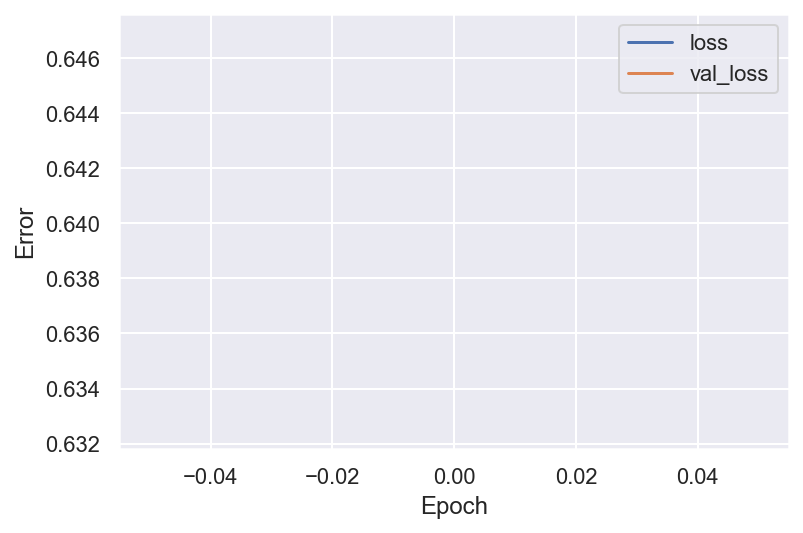

In [22]:
plot_loss(mod_history)

Get test set results & The test results on the models

In [14]:
ann_large = {}
for i in test_results.keys():
    ann_large[i] = f'{np.round(np.average(test_results[i]), 3)} +/- {np.round(np.std(test_results[i]), 3)}'

ann_large

{'loss': '0.635 +/- 0.003',
 'accuracy': '0.64 +/- 0.004',
 'recall': '0.645 +/- 0.061',
 'F1': '0.64 +/- 0.021'}